# Load data

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import requests

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
for file in ['time_series_covid19_confirmed_global.csv',
             'time_series_covid19_deaths_global.csv',
             'time_series_covid19_recovered_global.csv',
             'time_series_covid19_confirmed_US.csv',
             'time_series_covid19_deaths_US.csv']:
    print('Downloading {} ...'.format(file))
    get_data = requests.get(url + file)
    open(file, 'wb').write(get_data.content)

In [3]:
# load covid cases
confirmed_global = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed_global.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,48718,48952,49161,49378,49621,49681,49817,50013,50190,50433
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,49191,50000,50637,51424,52004,52542,53003,53425,53814,54317
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,92597,93065,93507,93933,94371,94781,95203,95659,96069,96549
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,7382,7382,7446,7466,7519,7560,7577,7602,7633,7669
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,16277,16362,16407,16484,16562,16626,16644,16686,16802,16931


In [4]:
# prepare dataframe
confirmed_global_country = confirmed_global.groupby(['Country/Region']).sum()
confirmed_global_country = confirmed_global_country.drop(columns = ['Lat','Long'])
confirmed_global_country = confirmed_global_country.T
confirmed_global_country.index = pd.to_datetime(confirmed_global_country.index)
confirmed_global_country.columns.name = None
confirmed_global_country.index.name = None
confirmed_global_country['World'] = confirmed_global_country.sum(axis=1)
confirmed_global_country_first = confirmed_global_country[:1]
confirmed_global_country = confirmed_global_country.diff()
confirmed_global_country = confirmed_global_country.dropna()
confirmed_global_country.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe,World
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,99.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,493.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,684.0
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,809.0


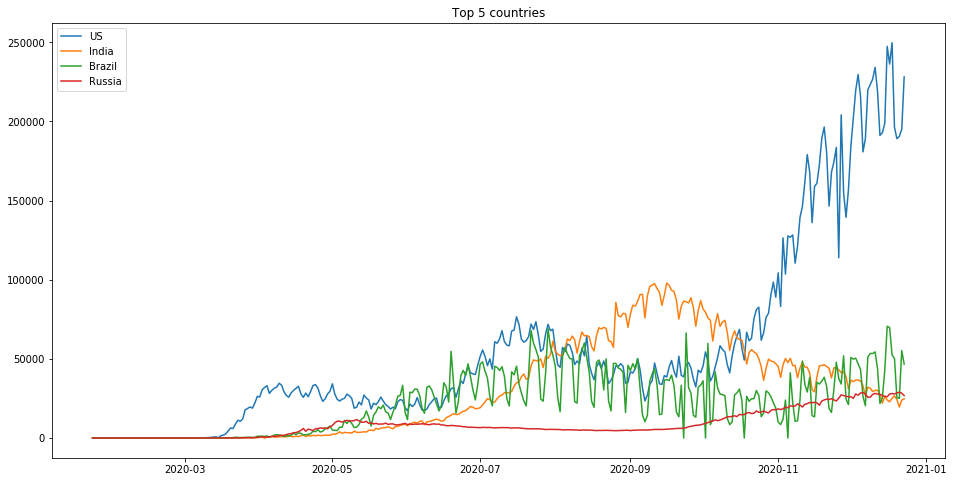

In [5]:
# plot top new cases countries
idx_top100 = confirmed_global_country.sum().sort_values(ascending=False).index[:100]
plt.figure(figsize=(16,8))
N = 5
plt.plot(confirmed_global_country[idx_top100[1:N]])
plt.legend(idx_top100[1:N])
plt.title('Top {} countries'.format(N))
plt.show()

In [6]:
train=confirmed_global_country[idx_top100[0:5].append(pd.Index(['Finland']))]
train.index.freq = 'D'
train_first = confirmed_global_country_first[idx_top100[0:5].append(pd.Index(['Finland']))]
train = train.dropna()
train

,World,US,India,Brazil,Russia,Finland
2020-01-23,99.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,287.0,1.0,0.0,0.0,0.0,0.0
2020-01-25,493.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,684.0,3.0,0.0,0.0,0.0,0.0
2020-01-27,809.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2020-12-19,616228.0,196295.0,26624.0,50177.0,27772.0,271.0
2020-12-20,534444.0,189099.0,24337.0,25445.0,28510.0,309.0
2020-12-21,541155.0,190519.0,19556.0,25019.0,28917.0,252.0
2020-12-22,646791.0,195033.0,23950.0,55202.0,28340.0,303.0


# Forecast

In [7]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [8]:
# Engineer new features: lags, rolling mean, diff and dates 
# all features are shifted by predict_days number to avoid data leak into prediction
def feature_engineering(df, predict_days = 7, lag_list = [0, 1, 7], drop_NAN = True, predict_future = False):
    df_new=df.copy()
    for feature in df.columns:
        for lag in lag_list:
            if predict_future:
                try: tmp
                except NameError:
                    tmp = pd.DataFrame({}, index=pd.date_range(train.index[-1]+pd.Timedelta(days=1), periods=predict_days, freq='D'))
                    df_new = df_new.append(tmp)
                df_new[feature + '_' + str(lag + predict_days)] = df_new[feature].shift(lag + predict_days)
                df_new[feature + '_rolling_' + str(lag + predict_days)] = df_new[feature + '_' + str(lag + predict_days)].rolling(7).mean()
                
            else:
                df_new[feature + '_' + str(lag + predict_days)] = df_new[feature].shift(lag + predict_days)
                df_new[feature + '_rolling_' + str(lag + predict_days)] = df_new[feature + '_' + str(lag + predict_days)].rolling(7).mean()
                
        df_new[feature + '_diff_' + str(0 + predict_days)] = df_new[feature + '_' + str(0 + predict_days)].diff(1)
        df_new[feature + '_diff_' + str(7 + predict_days)] = df_new[feature + '_' + str(0 + predict_days)].diff(7)
    
    if drop_NAN:
        df_new = df_new[lag + predict_days :]
        df_new = df_new.dropna()
            
        
    df_new['Day_year'] = df_new.index.dayofyear
    df_new['Day_week'] = df_new.index.dayofweek
    df_new['Day'] = df_new.index.day
    df_new['Month'] = df_new.index.month
    
    return df_new

In [9]:
training_columns = ['World','google_sum']
training_columns = ['World']
predict_days = 14
lag_list = [0]
lag_list = range(10)

train_set = feature_engineering(train['2020-01':][training_columns], 
                                predict_days = predict_days, 
                                lag_list = lag_list, 
                                drop_NAN = True, 
                                predict_future = True)

X_train   = train_set.drop(training_columns, axis=1)[:-predict_days]
y_train   = train_set[training_columns[0]][:-predict_days]
X_predict = train_set.drop(training_columns, axis=1)[-predict_days:]
y_predict   = train_set[training_columns[0]][-predict_days:]
train_set.head()

,World,World_14,World_rolling_14,World_15,World_rolling_15,World_16,World_rolling_16,World_17,World_rolling_17,World_18,...,World_22,World_rolling_22,World_23,World_rolling_23,World_diff_14,World_diff_21,Day_year,Day_week,Day,Month
2020-02-21,629.0,3593.0,3495.571429,3160.0,3224.000000,3745.0,3068.000000,4011.0,2617.142857,3100.0,...,2068.0,1083.000000,589.0,801.714286,433.0,1901.0,52,4,21,2
2020-02-22,1761.0,2734.0,3584.571429,3593.0,3495.571429,3160.0,3224.000000,3745.0,3068.000000,4011.0,...,1692.0,1283.714286,2068.0,1083.000000,-859.0,623.0,53,5,22,2
2020-02-23,380.0,3030.0,3339.000000,2734.0,3584.571429,3593.0,3495.571429,3160.0,3224.000000,3745.0,...,2111.0,1514.857143,1692.0,1283.714286,296.0,-1719.0,54,6,23,2
2020-02-24,564.0,2609.0,3268.857143,3030.0,3339.000000,2734.0,3584.571429,3593.0,3495.571429,3160.0,...,4749.0,2095.571429,2111.0,1514.857143,-421.0,-491.0,55,0,24,2
2020-02-25,853.0,2042.0,2987.571429,2609.0,3268.857143,3030.0,3339.000000,2734.0,3584.571429,3593.0,...,3100.0,2422.857143,4749.0,2095.571429,-567.0,-1969.0,56,1,25,2


### Forecast with ensembles 

RF score on train: 1.00 on test: 0.02
GB score on train: 1.00 on test: 0.05


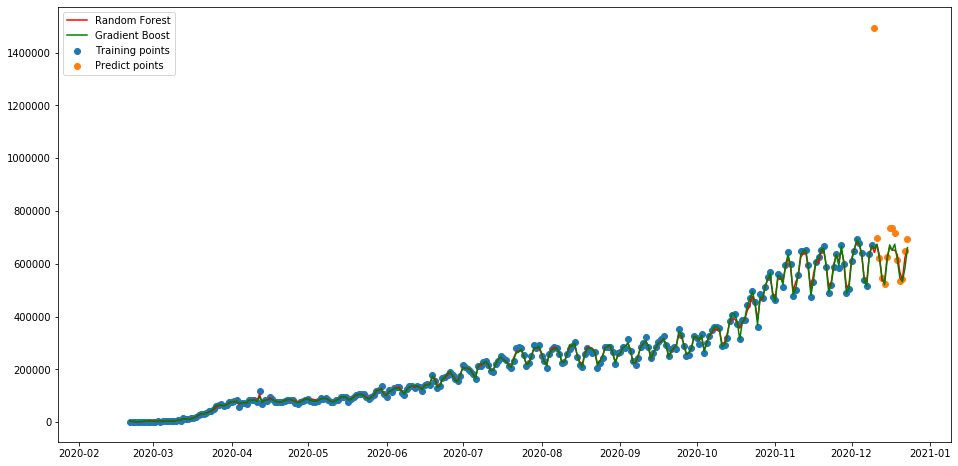

In [10]:
model_rf  = RandomForestRegressor(n_estimators=100)
model_gb  = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
model_svr = make_pipeline(StandardScaler(), SVR(C=100000,epsilon=0.1))
model_knn = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=3))

model_rf.fit(X_train,y_train)
model_gb.fit(X_train,y_train)

pred_rf = model_rf.predict(pd.concat([X_train, X_predict]))
pred_gb = model_gb.predict(pd.concat([X_train, X_predict]))
print('RF score on train: {:0.2f} on test: {:0.2f}'.format(model_rf.score(X_train,y_train), model_rf.score(X_predict,y_predict)))
print('GB score on train: {:0.2f} on test: {:0.2f}'.format(model_gb.score(X_train,y_train), model_gb.score(X_predict,y_predict)))

plt.figure(figsize=(16,8))
plt.scatter(X_train.index,y_train, label='Training points')
plt.scatter(X_predict.index,y_predict, label='Predict points')
plt.plot(pd.concat([X_train,X_predict]).index,pred_rf,'r-', label = 'Random Forest')
plt.plot(pd.concat([X_train,X_predict]).index,pred_gb,'g-', label = 'Gradient Boost')
plt.legend()
plt.show()

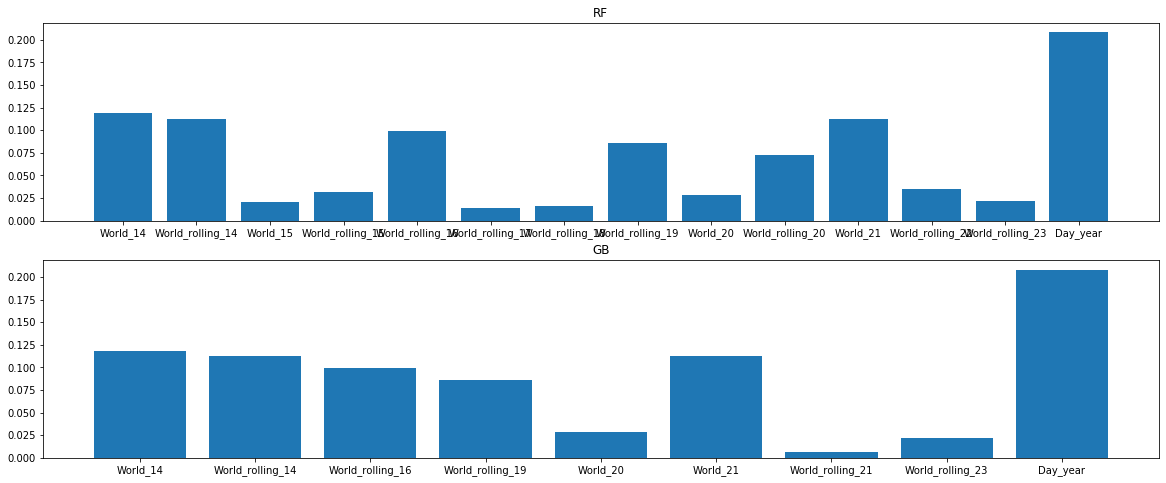

In [11]:
top_features_rf = model_rf.feature_importances_[model_rf.feature_importances_>0.01]
top_features_rf_labels = X_train.columns.values[model_rf.feature_importances_>0.01]
top_features_gb = model_rf.feature_importances_[model_gb.feature_importances_>0.01]
top_features_gb_labels = X_train.columns.values[model_gb.feature_importances_>0.01]

plt.figure(figsize=(20,8))
plt.subplot(211)
plt.bar(range(len(top_features_rf)), top_features_rf, tick_label = top_features_rf_labels)
plt.title('RF')
plt.subplot(212)
plt.bar(range(len(top_features_gb)), top_features_gb, tick_label = top_features_gb_labels)
plt.title('GB')
plt.show()

### Forecast with Prophet

In [12]:
from fbprophet import Prophet

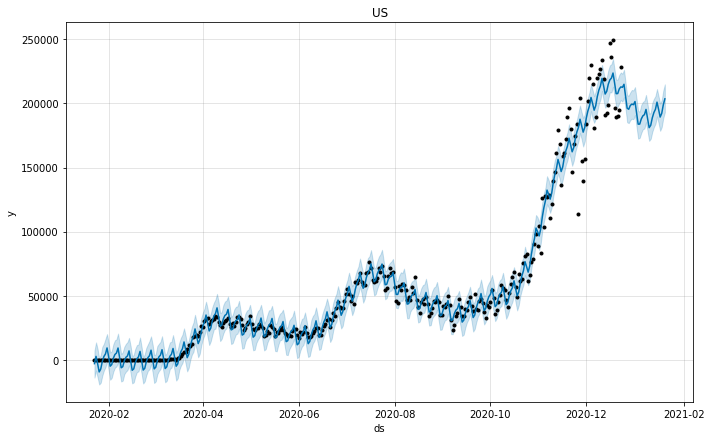

In [13]:
df_prophet = pd.DataFrame()
country = 'US'
start_data='2020-01'
df_prophet['ds'] = train[start_data:].index
df_prophet['y']  = (train[start_data:][country].values)

model_prophet = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=True,  
    daily_seasonality=False,
    seasonality_mode='additive')
model_prophet.fit(df_prophet);

df_prophet_future = model_prophet.make_future_dataframe(periods=28)
df_prophet_forecast = model_prophet.predict(df_prophet_future)
df_prophet_forecast.head()

model_prophet.plot(df_prophet_forecast)
plt.title(country)
plt.show()

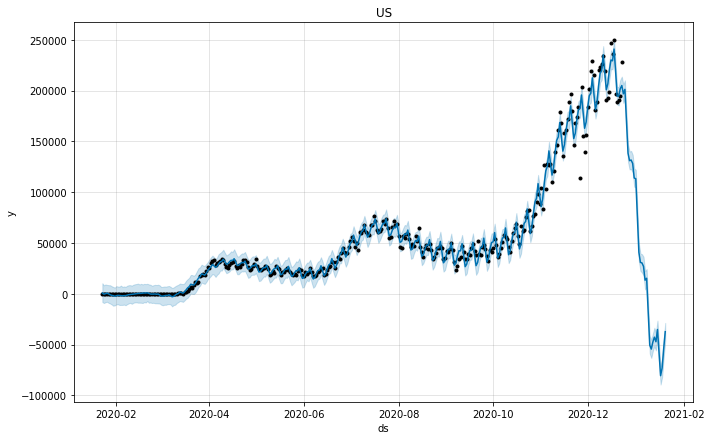

In [14]:
# Note log scale and weekly seasonality 
country = 'US'
start_data='2020-01'

df_prophet = pd.DataFrame()
df_prophet['ds'] = train[start_data:].index
df_prophet['y']  = (train[start_data:][country].values)

model_prophet = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=True,  
    daily_seasonality=False,
    seasonality_mode='multiplicative')
model_prophet.fit(df_prophet)

df_prophet_future = model_prophet.make_future_dataframe(periods=28)
df_prophet_forecast = model_prophet.predict(df_prophet_future)
df_prophet_forecast.head()

model_prophet.plot(df_prophet_forecast)
plt.title(country)
plt.show()

### Forecast with LSTM

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [16]:
# prepare lag features for input
def gen_features(data, lag = 7):
    X = []
    y = []
    for i in range(len(data) - lag):
        X.append(data[i : i + lag])
        y.append(data[i + lag])
    return np.array(X), np.array(y)

def gen_features_vector(data, lag = 7, predict = 7):
    X = []
    y = []
    for i in range(len(data) - lag - predict):
        X.append(data[i : i + lag])
        y.append(data[i + lag : i + lag + predict])
    return np.array(X), np.array(y)


In [18]:
# Vector output
country = 'Finland'
lag = 7*4
predict_days = 7*3

scaler = MinMaxScaler()
train_norm = scaler.fit_transform(train[[country]])

train_X, train_y = gen_features_vector(train_norm, lag, predict_days)
print('Shape X : {}\nShape y : {}'.format(train_X.shape, train_y.shape))

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
print('Shape X : {}\nShape y : {}'.format(train_X.shape, train_y.shape))

units = 256
num_epoch = 10


model = keras.Sequential()
model.add(layers.LSTM(units, input_shape=(train_X.shape[1], 1)))
#model.add(layers.LSTM(units))
model.add(layers.Dense(predict_days, activation = 'linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.fit(train_X, train_y, epochs=num_epoch, batch_size=1, verbose=2)

predict_vector = scaler.inverse_transform(model.predict(train_norm[-lag:].reshape((1, lag, 1))).reshape(-1,1))

Shape X : (287, 28, 1)
Shape y : (287, 21, 1)
Shape X : (287, 28, 1)
Shape y : (287, 21, 1)
Epoch 1/10
287/287 - 6s - loss: 0.0167 - mae: 0.0829
Epoch 2/10
287/287 - 6s - loss: 0.0091 - mae: 0.0623
Epoch 3/10
287/287 - 5s - loss: 0.0088 - mae: 0.0614
Epoch 4/10
287/287 - 5s - loss: 0.0082 - mae: 0.0593
Epoch 5/10
287/287 - 5s - loss: 0.0084 - mae: 0.0584
Epoch 6/10
287/287 - 5s - loss: 0.0078 - mae: 0.0566
Epoch 7/10
287/287 - 6s - loss: 0.0077 - mae: 0.0568
Epoch 8/10
287/287 - 6s - loss: 0.0075 - mae: 0.0552
Epoch 9/10
287/287 - 7s - loss: 0.0074 - mae: 0.0552
Epoch 10/10
287/287 - 9s - loss: 0.0072 - mae: 0.0539


In [19]:
#country = 'US'
#lag = 7*4

scaler = MinMaxScaler()
train_norm = scaler.fit_transform(train[[country]])

train_X, train_y = gen_features(train_norm, lag)
print('Shape X : {}\nShape y : {}'.format(train_X.shape, train_y.shape))

train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
print('Shape X : {}\nShape y : {}'.format(train_X.shape, train_y.shape))

Shape X : (308, 28, 1)
Shape y : (308, 1)
Shape X : (308, 1, 28)
Shape y : (308, 1)


In [20]:
#units = 128
#num_epoch = 10

model = keras.Sequential()
model.add(layers.LSTM(units, input_shape=(1, train_X.shape[2])))
#model.add(layers.LSTM(units, return_sequences=True, input_shape=(1, train_X.shape[2])))
#model.add(layers.Bidirectional(layers.LSTM(units, input_shape=(1, train_X.shape[2]))))
#model.add(layers.LeakyReLU(alpha=0.5))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation = 'linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.fit(train_X, train_y, epochs=num_epoch, batch_size=1, verbose=2)


Epoch 1/10
308/308 - 1s - loss: 0.0079 - mae: 0.0553
Epoch 2/10
308/308 - 1s - loss: 0.0060 - mae: 0.0454
Epoch 3/10
308/308 - 1s - loss: 0.0058 - mae: 0.0437
Epoch 4/10
308/308 - 1s - loss: 0.0049 - mae: 0.0429
Epoch 5/10
308/308 - 1s - loss: 0.0048 - mae: 0.0407
Epoch 6/10
308/308 - 1s - loss: 0.0046 - mae: 0.0428
Epoch 7/10
308/308 - 1s - loss: 0.0045 - mae: 0.0387
Epoch 8/10
308/308 - 1s - loss: 0.0048 - mae: 0.0414
Epoch 9/10
308/308 - 1s - loss: 0.0048 - mae: 0.0414
Epoch 10/10
308/308 - 1s - loss: 0.0044 - mae: 0.0411


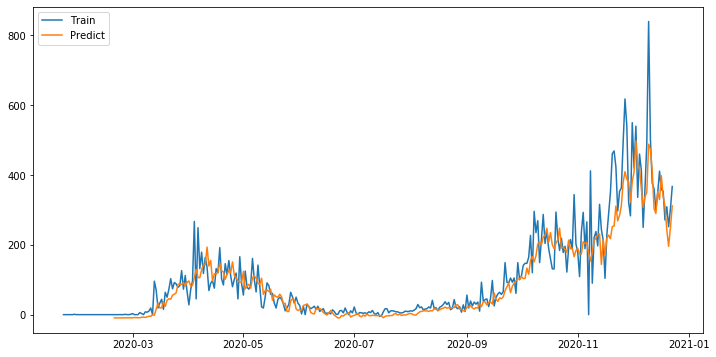

In [21]:
predict_train = scaler.inverse_transform(model.predict(train_X))

plt.figure(figsize=(12,6))
plt.plot(train[country])
plt.plot(train.index[lag:],predict_train)
plt.legend(['Train', 'Predict'])
plt.show()

In [22]:
# future prediction

predict_future_norm = []
train_norm_new = train_norm.copy()
for i in range(predict_days):
    #print('i = {}'.format(i))
    future_X = np.reshape(train_norm_new[-lag:],(1,1,lag))
    predict_future_norm.append(model.predict(future_X))
    train_norm_new = np.append(train_norm_new,predict_future_norm[i])
predict_future_norm = np.array(predict_future_norm)  

predict_future = scaler.inverse_transform(predict_future_norm.reshape(-1,1))

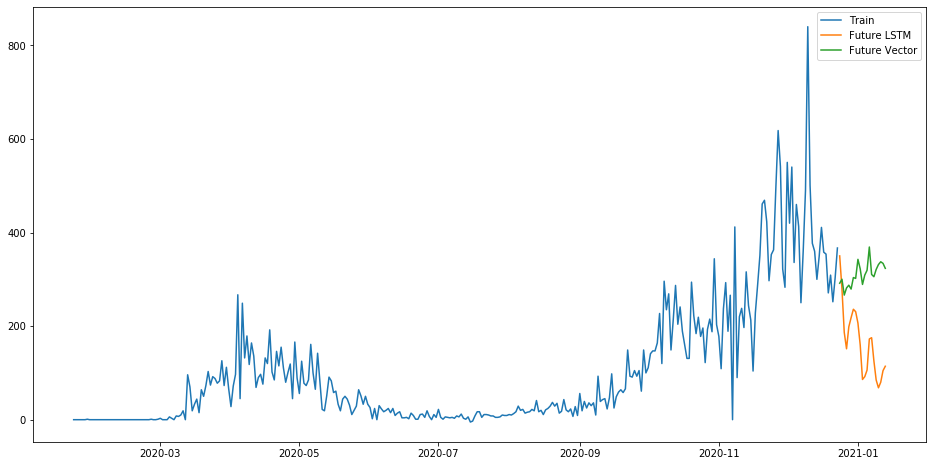

In [23]:
# Plot all

plt.figure(figsize=(16,8))
plt.plot(train[country])
#plt.plot(train.index[lag:], predict_train)
plt.plot(pd.date_range(train.index[-1]+pd.Timedelta(days=1), periods=predict_days), predict_future)

plt.plot(pd.date_range(train.index[-1]+pd.Timedelta(days=1), periods=predict_days), predict_vector)

plt.legend(['Train', 'Future LSTM', 'Future Vector'])
plt.show()